# Grid Searching

## load feature extracted data

In [43]:
from feature_extraction_pipeline.open_data_marine_weather.core import MarineWeatherExtractor
from feature_extraction_pipeline.open_data_raw_material_price.core import RawMaterialPriceExtractor
from feature_extraction_pipeline.open_data_terrestrial_weather.core import TerrestrialWeatherExtractor
import pandas as pd
import numpy as np



def load_data(date: str):
    price, p_key = RawMaterialPriceExtractor(date=date).process()
    t_weather, t_key = TerrestrialWeatherExtractor(date=date).process()
    m_weather, m_key = MarineWeatherExtractor(date=date).process()

    # combine data
    weather = pd.merge(
        t_weather.groupby(["일시"]).mean(),
        m_weather.groupby(["일시"]).mean(),
        how='inner', left_on=t_key, right_on=m_key
    ).reset_index()

    return pd.merge(
        price, weather, 
        how="left", left_on=p_key, right_on=t_key
    ).drop("일시", axis=1).astype(dtype={"조사일자": "datetime64"})

data201908 = load_data("201908")
data201907 = load_data("201907")

# some categories doesn't exist at the same time on both dates.
# dataset = data201908.append(data201907).sort_values(by="조사일자", ascending=True)


2020-03-31 13:40:47:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'
2020-03-31 13:40:47:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-31 13:40:47:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-31 13:40:48:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201907.csv in s3 'production-bobsim'
2020-03-31 13:40:48:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201907.csv in s3 'production-bobsim'
2020-03-31 13:40:49:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201907.csv in s3 'production-bobsim'


Empty DataFrame
Columns: [조사일자, 당일조사가격, 품목명_갈치류갈치은갈치냉동, 품목명_갈치류갈치은갈치생선, 품목명_감자감자수미수미, 품목명_건가공(포)류건오징어오징어포일반, 품목명_건가공(해조)류건미역자연미역일반, 품목명_건제품건포도건포도(수입)수입, 품목명_고구마고구마(밤)밤고구마고구마(일반), 품목명_고등어류고등어고등어(수입)수입, 품목명_고등어류고등어망치고등어냉동, 품목명_고등어류고등어망치고등어생선, 품목명_고등어류고등어망치고등어염장, 품목명_고추건고추양건고추양건, 품목명_고추건고추햇양건고추햇산양건, 품목명_고추건고추햇화건고추햇산화건, 품목명_고추건고추화건고추화건, 품목명_고추붉은고추홍고추일반, 품목명_고추풋고추꽈리고추꽈리고추, 품목명_고추풋고추청양청양고추, 품목명_고추풋고추청초일반고추, 품목명_김류김김일반, 품목명_깻잎깻잎깻잎(일반)일반, 품목명_꽁치류꽁치꽁치(수입)수입냉동, 품목명_녹두녹두녹두(일반)국산, 품목명_느타리버섯느타리버섯기타일반, 품목명_닭고기닭고기통닭도계, 품목명_당근당근흙당근무세척, 품목명_대파파대파(일반)대파, 품목명_돈육돼지고기갈비갈비, 품목명_돈육돼지고기목심살목살, 품목명_돈육돼지고기삼겹살(수입)삼겹살(수입냉동), 품목명_돈육돼지고기삼겹살삼겹살(국산냉장), 품목명_돈육돼지고기앞다리살앞다리살, 품목명_땅콩땅콩땅콩(수입)수입, 품목명_땅콩땅콩땅콩(일반)국산, 품목명_레몬레몬레몬(수입)수입, 품목명_메론멜론네트계일반, 품목명_멸치류건멸치멸치일반, 품목명_명태류명태명태냉동, 품목명_무무고냉지무고랭지, 품목명_미나리미나리미나리(일반)일반, 품목명_바나나바나나바나나(수입)수입, 품목명_방울토마토방울토마토기타국산, 품목명_배배신고신고, 품목명_배배원황원황, 품목명_배추배추고냉지배추고랭지, 품목명_배추얼갈이배추얼갈이배추일반, 품목명_벼쌀일반계일반계, 품목명_복숭아복숭아백도백도, 품목명_블루베리건블루베리건블루베리(수입)수입, 품목명_사과사과아오리쓰가루, 품목명_사과사과후지후지, 품목명_상추상추적상추적, 품목명_상추상추청상추청,

## adjust train volume fixing test last one day

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import functools

def customized_rmse(y, y_pred):
    error = y - y_pred
    def penalize(x):
        if x > 0:
            # if y > y_pred, penalize 10%
            return x * 1.1
        else:
            return x
    X = np.vectorize(penalize)(error)
    return np.sqrt(np.square(X).mean())

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]

def split_train_test(start, standard, df: pd.DataFrame):
    train = df[(start <= df.조사일자.dt.date) & (df.조사일자.dt.date < standard)]
    test = df[df.조사일자.dt.date >= standard]
    return train, test

def get_score(x, day, df):
    train, test = split_train_test(x, day, df)
    
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_train)
    
    r_pred = np.expm1(y_pred)
    r_test = np.expm1(y_train)
    metric = customized_rmse(r_test, r_pred)
    return metric



In [38]:
def find_train_test(i, df):
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(get_score, day=standard_day, df=data201908), reverse_list[i+1:]))
    pd.Series(score_list, index=reverse_list[i+1:]).plot()
    print("metric list for standard '{day}': {metrics}".format(day=standard_day, metrics=score_list))


metric list for standard '2019-08-30 00:00:00': [516.2369191992868, 533.534066160313, 517.2663951492603, 520.9860341450445, 521.1195022266334, 526.1557467260719, 529.1379986395228, 530.4486230496124, 526.8855786158105, 525.9836076889909, 523.9888132486765, 521.959627288044, 521.6057765621562, 522.6054238900383, 523.5119092550519, 525.0885691757991, 525.8601574831999, 525.7284164381888, 525.8056105336502, 524.9682761326814]
metric list for standard '2019-08-29 00:00:00': [511.4396384500484, 503.8277168268934, 517.9640492580542, 519.6999311675751, 526.4530133890686, 528.7712179901463, 529.6318033243011, 525.8125968061705, 525.2271430934089, 522.9794281432879, 520.5800518820967, 520.278192613761, 520.9911769169225, 522.2463709226676, 524.0949259188338, 524.6787248838468, 523.866550581565, 524.7178500850224, 523.8434323840968]
metric list for standard '2019-08-28 00:00:00': [501.67265895031005, 519.3676178702098, 521.2768463780193, 526.2842084078911, 529.9953015375448, 531.2076554581683, 5

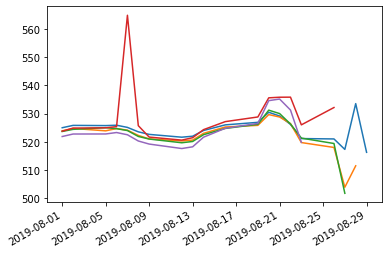

In [39]:
for i in range(0,5):
    find_train_test(i, data201908)

In [ ]:
for i in range(5,10):
    find_train_test(i, data201908)


## Grid Search for ElasticNet

### split train and test

In [52]:
def train_test(df, index):
    i = index
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()    
    return df[df.조사일자.dt.date < reverse_list[i]], df[df.조사일자.dt.date >= reverse_list[i]]

train1, test1 = train_test(data201908, 7)
X_train1, Y_train1 = split_xy(train1)
X_test1, Y_test1 = split_xy(test1)

train2, test2 = train_test(data201907, 7)
X_train2, Y_train2 = split_xy(train2)
X_test2, Y_test2 = split_xy(test2)

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error

### search proper params

In [54]:
def grid_search(X_train, Y_train, X_test, Y_test):
    # Use grid search to tune the parameters:
    params ={
                "max_iter": [1, 5, 10], # , 50, 100, 500, 1000],
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                "l1_ratio": np.arange(0.0, 1.0, 0.1)
            }

    eNet = ElasticNet()
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(eNet, params, scoring=make_scorer(customized_rmse, greater_is_better=False), cv=tscv.split(X_train))
    grid.fit(X_train, Y_train)
    return grid

In [55]:
grid1 = grid_search(X_train1, Y_train1, X_test1, Y_test1)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.46536745891646, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.54710233955774, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.6813159231018, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.653852110717025, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.00954568439064, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.2660025831306, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.686040633264014, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.96859530671159, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.68165216066336, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.0156326849233, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1132.5431730553241, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379.60733762423274, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.7564698682227, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.8190734003955, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.30267801532796, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.2173352815727, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1399.6136604041737, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.859077728075391, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678.0527322903272, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3331.437114491313, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4966.388574901806, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.911521755278045, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.0998838687647, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2634.0281785725424, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3381.650462424156, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6714.918984645354, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10028.480773962336, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

### searhed best params

In [57]:
grid1.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.9, 'max_iter': 10}

### test bset estimator

In [58]:
elastic_net = grid1.best_estimator_
elastic_net

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=10, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [86]:
def test_estimator(X_train, Y_train, X_test, Y_test):
    print("********* For fianl model *********")
    
    # retrain model
    elastic_net = grid1.best_estimator_
    elastic_net.fit(X_train, Y_train)
    print("score for train/test: {train}/{test}".format(
        train=elastic_net.score(X_train, Y_train), test=elastic_net.score(X_test, Y_test))
    )
    
    # customized RMSE metrics for testset
    Y_pred = pd.Series(elastic_net.predict(X_test))
    r_pred = np.expm1(Y_pred).rename("pred")
    r_test = np.expm1(Y_test).rename("test").reset_index(drop=True)

    print("---test & pred---")
    print(r_test.to_frame().join(r_pred))
    print("customized rmse: ", customized_rmse(r_test, r_pred))
    return elastic_net

# ela = test_estimator(X_train, Y_train, X_test, Y_test) 
# plot_coef(ela)

ela1 = test_estimator(X_train1, Y_train1, X_test1, Y_test1) 
ela2 = test_estimator(X_train2, Y_train2, X_test2, Y_test2) 

# Y_pred = elastic_net.predict(X_test)

********* For fianl model *********
score for train/test: 0.9725838253973863/0.9598959925335062
---test & pred---
              test         pred
0       238.000000   222.769069
1       870.000000   980.949745
2       990.000000  1234.684649
3      1320.000000  1191.898400
4      1050.000000   953.214863
...            ...          ...
15347  1566.000000  1423.261884
15348  1166.000000  1325.172913
15349   714.000000   629.416059
15350  1058.000000   812.283206
15351  2016.666667  1214.818315

[15352 rows x 2 columns]
customized rmse:  593.9406734398068
********* For fianl model *********


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.0252481361356, tolerance: 2.661601832948214
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.0188527091915, tolerance: 3.01656320582926
  positive)


score for train/test: 0.9761425840185298/0.9646916194502201
---test & pred---
              test         pred
0       258.000000   232.973331
1      1450.000000  1008.760912
2      1050.000000  1354.967176
3      1120.000000  1073.748274
4      1120.000000   937.578751
...            ...          ...
15451  1566.000000  1569.514129
15452  1166.000000  1356.528559
15453   714.000000   624.593173
15454  1058.000000   848.484018
15455  2383.333333  2593.798280

[15456 rows x 2 columns]
customized rmse:  582.8808081026499


### coef graph

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

def plot_coef(model, X_train):
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    return coef_sort

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48521 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49709 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

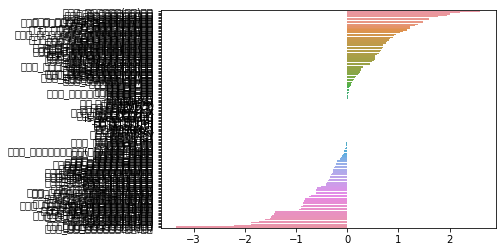

In [101]:
coef_series = plot_coef(ela1, X_train1)

품목명_수박수박수박(일반)일반       2.58821
품목명_한우쇠고기안심안심          2.18445
품목명_한우쇠고기등심한우등심        1.99201
품목명_포도포도거봉거봉           1.92981
품목명_메론멜론네트계일반          1.76361
                        ...   
품목명_감자감자수미수미          -1.73316
품목명_열무열무열무(일반)일반      -1.87884
품목명_배추얼갈이배추얼갈이배추일반    -1.89022
품목명_양파양파기타양파(일반)      -2.20527
품목명_미나리미나리미나리(일반)일반   -3.33811
Length: 150, dtype: float64

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47308 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44405 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

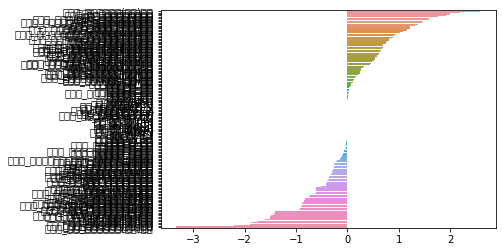

In [390]:
plot_coef(ela2, X_train2)

In [139]:
pd.options.display.float_format = '{:,.200f}'.format

final = coef_series.reset_index().rename(columns={"index": "col", 0: "val"})
absolute = final.assign(absolute = lambda x: abs(x.val))
absolute.sort_values("absolute", ascending=True).head(50).drop("val", axis=1)

,col,absolute
74,평균 기온(°C),0.000000000000000000000000000000000000000000000...
81,최고 파주기(sec),0.000000000000000000000000000000000000000000000...
80,평균 파주기(sec),0.000000000000000000000000000000000000000000000...
79,season_3,0.000000000000000000000000000000000000000000000...
78,최고 최대 파고(m),0.000000000000000000000000000000000000000000000...
77,최고 유의 파고(m),0.000000000000000000000000000000000000000000000...
76,평균 유의 파고(m),0.000000000000000000000000000000000000000000000...
75,평균 최대 파고(m),0.000000000000000000000000000000000000000000000...
72,품목명_배배원황원황,0.000000000000000000000000000000000000000000000...
71,품목명_명태류명태명태냉동,0.000000000000000000000000000000000000000000000...


In [130]:
absolute.sort_values("absolute", ascending=False).drop("val", axis=1)[60:120]

,col,absolute
32,품목명_사과사과후지후지,0.543829
33,품목명_젓갈(일반)류새우젓새우젓일반,0.534303
34,품목명_생강생강생강(일반)국산,0.523468
121,품목명_참깨참깨참깨(수입)인도참깨,0.502984
35,품목명_돈육돼지고기목심살목살,0.487366
36,품목명_대파파대파(일반)대파,0.453646
37,품목명_쇠고기쇠고기갈비살(수입)미국산갈비살,0.452988
120,품목명_상추상추적상추적,0.414923
119,품목명_오이오이취청취청,0.405595
118,품목명_상추상추청상추청,0.392304


In [132]:
absolute.sort_values("absolute", ascending=False).drop("val", axis=1)[119:180]

,col,absolute
90,품목명_당근당근흙당근무세척,0.011027
60,조사지역명_부산,0.007004
89,강수 계속시간(hr),0.004867
88,조사지역명_경북포항,0.004144
87,평균기온(°C),0.003117
61,최저기온(°C),0.002827
86,조사지역명_전남순천,0.001902
85,최고기온(°C),0.000655
62,평균기압(hPa),0.000606
84,평균 풍속(m/s)_y,0.000560


In [ ]:

m_list = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최대 풍속(m/s)', '평균 풍속(m/s)', '최소 상대습도(pct)', '평균 상대습도(pct)', '합계 일조시간(hr)', '강수 계속시간(hr)', '일강수량(mm)']

def func(x):
    print(final[final.col == x])
    return None

list(map(func , m_list))